In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc 

# Obtain pseudoalignments

This code assembles a bash script that downloads unfiltered kallisto|bustools outputs. Afterward, the bash script is run separately.

In [3]:
meta = pd.read_csv('/home/ec2-user/curation/arduini/meta.csv')

In [4]:
meta['tissue'].value_counts()

tissue
Left ventricle region 2B    28
Left ventricle region 2A    12
Left ventricle region 2C    12
Left ventricle region 1B    12
Left ventricle region 3B    12
Name: count, dtype: int64

In [5]:
meta['individual_or_pool'].value_counts()

individual_or_pool
chambers_14    16
chambers_13    16
chambers_11    16
chambers_6      4
chambers_7      4
chambers_5      4
chambers_3      4
chambers_4      4
chambers_1      4
chambers_2      4
Name: count, dtype: int64

In [6]:
meta.iloc[0]

Run                                                           SRR31090443
Assay Type                                                        RNA-Seq
AvgSpotLen                                                            132
Bases                                                          3665219052
BioProject                                                   PRJNA1176479
BioSample                                                    SAMN44404548
Bytes                                                          1796703549
Center Name                       LAB OF PATRICK ELLINOR, BROAD INSTITUTE
Collection_Date                                                   missing
Consent                                                            public
DATASTORE filetype                                       fastq,run.zq,sra
DATASTORE provider                                             gs,ncbi,s3
DATASTORE region                     gs.us-east1,ncbi.public,s3.us-east-1
Developmental_Stage                   

In [7]:
meta['sample_names'] = 'A_LV'+meta['individual_or_pool'].str.split('_').str[-1]+'_'+meta['tissue'].str.split(' ').str[-1]

In [8]:
meta['sample_names'].unique()
samples = meta['sample_names'].unique()
rootdir = '/home/ec2-user/curation/arduini/kb_2503/kallisto/'


In [102]:
lines = []
lines.append('mkdir -p '+rootdir)

for sample in samples:
    src = f's3://gennady-wip/curation/arduini/kb_2503/kallisto/{sample}.count/counts_unfiltered/'
    dest = f'{rootdir}/{sample}/counts_unfiltered/'
    lines.append('mkdir -p '+dest)
    for file in ['cells_x_genes.total.mtx','cells_x_genes.barcodes.txt','cells_x_genes.genes.names.txt']:
        lines.append(f'aws s3 cp {src}{file} {dest}')


In [103]:
lines = [x+'\n' for x in lines]

In [104]:

with open('/home/ec2-user/curation/arduini/get_unfiltered.sh', "w") as file:
    file.writelines(lines)


# Load pseudoalignments

In [9]:
import tqdm

In [10]:
ads = []
for sample in tqdm.tqdm(samples):
    # print(sample)
    samp_dir =  f'{rootdir}/{sample}/counts_unfiltered/'
    bcs = np.loadtxt(samp_dir+'cells_x_genes.barcodes.txt',dtype=str)
    genes = np.loadtxt(samp_dir+'cells_x_genes.genes.names.txt',dtype=str)
    ad = sc.read_mtx(samp_dir+'cells_x_genes.total.mtx')
    ad.var.index = genes
    ad.obs.index = bcs
    ads.append(ad)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [03:38<00:00, 11.53s/it]


In [11]:
knees = []
for ad in ads:
    knee = np.sort((np.array(ad.X.sum(axis=1))).flatten())[::-1]
    knees.append(knee)


Text(0, 0.5, 'UMI counts')

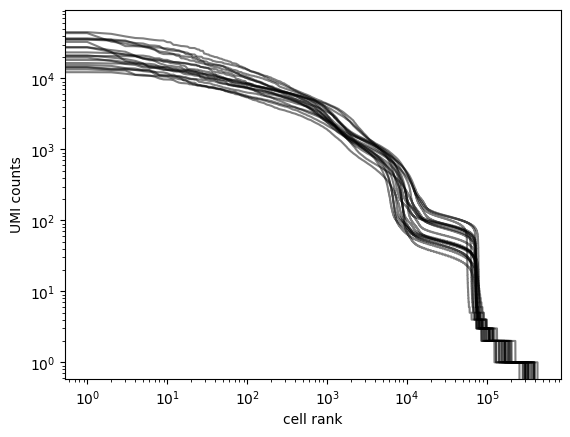

In [12]:
for i in range(len(ads)):
    plt.plot(range(len(knees[i])),knees[i],color='k',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('cell rank')
plt.ylabel('UMI counts')


In [13]:
ad_ratmap=sc.read_h5ad('/home/ec2-user/curation/arduini/ratmap_scp.h5ad')

In [14]:
ad_ratmap=ad_ratmap[ad_ratmap.obs['tissue']=='LV']

In [15]:
ad_ratmap.obs['bcs'] = ad_ratmap.obs.index.str.split(':').str[-1].str.split('-').str[0]

/tmp/ipykernel_26345/3172692170.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad_ratmap.obs['bcs'] = ad_ratmap.obs.index.str.split(':').str[-1].str.split('-').str[0]


In [16]:
ad_ratmap.obs.iloc[0]

In [17]:
ad_ratmap.obs['leiden1p2_labels'].cat.categories.sort_values()

Index(['0: Fibroblasts 1', '10: Vascular Smooth Muscle Cells 1',
       '11: Endothelial Cells 3', '12: Brown Adipocytes',
       '13: Lymphatic Endothelial Cells', '14: Mesothelial Cells',
       '15: White Adipocytes', '16: Monocytes', '17: Neuronal', '18: B Cells',
       '19: Vascular Smooth Muscle Cells 2', '1: Endothelial Cells 1',
       '21: Top2a+ Endothelial Cells ', '22: Antigen Presenting Cells',
       '23: Club Cells', '24: Ganglionic plexi neurons',
       '25: Fmod+ Fibroblasts', '2: Fibroblasts 2',
       '3: Ventricular Cardiomyocytes', '4: Fibroblasts 3',
       '5: Endothelial Cells 2', '6: Macrophages', '7: Pericytes',
       '8: T Cells', '9: Atrial Cardiomyocytes'],
      dtype='object')

In [18]:
gene = 'Xist'
y=[]
for i,sample in enumerate(samples):
    cf = ad_ratmap.obs['biosample_id'].str.startswith(sample) & (ad_ratmap.obs['leiden1p2_labels']=='17: Neuronal')
    kb_num = ads[i][ads[i].obs.index.isin(ad_ratmap[cf].obs['bcs']),gene].X.sum()
    y.append(kb_num)
print(np.array(y,dtype=int))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [19]:
[x[:,'Xist'].X.sum() for x in ads]

[1.0,
 0.0,
 0.0,
 0.0,
 4.0,
 0.0,
 0.0,
 0.0,
 1.0,
 2.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0]

In [20]:
gene = 'LOC134484082'
y=[]
for i,sample in enumerate(samples):
    cf = ad_ratmap.obs['biosample_id'].str.startswith(sample) & (ad_ratmap.obs['leiden1p2_labels']=='17: Neuronal')
    kb_num = ads[i][ads[i].obs.index.isin(ad_ratmap[cf].obs['bcs']),gene].X.sum()
    y.append(kb_num)
print(np.array(y,dtype=int))

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [61]:
[int(x[:,'LOC134484082'].X.sum()) for x in ads]

[93,
 97,
 135,
 125,
 204,
 54,
 84,
 84,
 53,
 71,
 130,
 59,
 92,
 143,
 108,
 55,
 76,
 66,
 67]

In [63]:
y=[]
for i,sample in enumerate(samples):
    num=ad_ratmap.raw[ad_ratmap.obs['biosample_id'].str.startswith(sample),'LOC680227'].X.sum()
    y.append(num)
print(np.array(y,dtype=int))
print(min(y),max(y))

[32 28 27 18 39 15 16 13  9 16 34 15 24 44 34 18 11 13 19]
9.0 44.0


In [24]:
print(min([x[:,'Xist'].X.sum() for x in ads]),max([x[:,'Xist'].X.sum() for x in ads]))

0.0 4.0


In [22]:
print(min([x[:,'LOC134484082'].X.sum() for x in ads]),max([x[:,'LOC134484082'].X.sum() for x in ads]))

53.0 204.0


In [37]:
'LOC100911498' in ad_ratmap.var_names

False

In [42]:
'LOC680227' in ad_ratmap.var_names

True

In [41]:
 "LOC103690048" in ad_ratmap.var_names

True

Compare barcodes from the released data and the kallisto|bustools outputs. The latter are a strict superset of the former, since both alignments used the 10x whitelist and kb was run without filtering.

In [23]:
for i,sample in enumerate(samples):
    bcs_kb = ads[i].obs.index
    bcs_ratmap = ad_ratmap[ad_ratmap.obs['biosample_id'].str.startswith(sample)].obs['bcs']
    overlap1 = np.round(100*bcs_ratmap.isin(bcs_kb).mean(),4)
    overlap2 = np.round(100*bcs_kb.isin(bcs_ratmap).mean(),4)
    print(f'Sample {sample}.\n\tPercentage of ratmap BCs in kb: {overlap1}.\n\tPercentage of kb BCs in ratmap: {overlap2}.')


Sample A_LV14_2A.
	Percentage of ratmap BCs in kb: 100.0.
	Percentage of kb BCs in ratmap: 1.8397.
Sample A_LV13_2C.
	Percentage of ratmap BCs in kb: 100.0.
	Percentage of kb BCs in ratmap: 2.4714.
Sample A_LV14_1B.
	Percentage of ratmap BCs in kb: 100.0.
	Percentage of kb BCs in ratmap: 1.9926.
Sample A_LV13_3B.
	Percentage of ratmap BCs in kb: 100.0.
	Percentage of kb BCs in ratmap: 2.0901.
Sample A_LV13_1B.
	Percentage of ratmap BCs in kb: 100.0.
	Percentage of kb BCs in ratmap: 2.4736.
Sample A_LV13_2A.
	Percentage of ratmap BCs in kb: 100.0.
	Percentage of kb BCs in ratmap: 1.6381.
Sample A_LV6_2B.
	Percentage of ratmap BCs in kb: 100.0.
	Percentage of kb BCs in ratmap: 2.668.
Sample A_LV7_2B.
	Percentage of ratmap BCs in kb: 100.0.
	Percentage of kb BCs in ratmap: 3.0416.
Sample A_LV5_2B.
	Percentage of ratmap BCs in kb: 100.0.
	Percentage of kb BCs in ratmap: 2.5931.
Sample A_LV3_2B.
	Percentage of ratmap BCs in kb: 100.0.
	Percentage of kb BCs in ratmap: 2.1775.
Sample A_LV11_2